In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from random import random

In [2]:
np.array(1)

array(1)

In [3]:
import os

In [4]:
from lcmcmc.utils import get_data_dir_path

In [5]:
from kndetect.utils import load_pcs



pcs = load_pcs()# Load data

In [6]:
pcs = load_pcs()

In [7]:
new_object_df = pd.read_csv(os.path.join(get_data_dir_path(), "perfect_sims.csv"))

The perfect simulations are simulated for LSST so they have 6 differnet bands. Since right now we run the tests on the ZTF data which has only the g and r bands, we will use only these 2 from LSST for compution

# RUN MCMC

In [8]:
from lcmcmc.model import jd_model_pcs
import jax.numpy as jnp
import jax
import tensorflow_probability.substrates.jax as tfp

2023-06-16 13:53:07.722863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
rng = jax.random.PRNGKey(7)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [10]:
new_object_df=new_object_df[new_object_df["object_index"]<10]

In [11]:
index = np.zeros((len(new_object_df), 2), dtype=np.int32)

index[:, 0] = np.asarray(new_object_df["object_index"].values)
index[:, 1] = np.asarray(new_object_df["band_index"].values)

x_range = jnp.asarray(new_object_df["time"])

observed_value = np.array(new_object_df["flux"].values, dtype=jnp.float32)
observed_sigma = np.array(new_object_df["fluxerr"].values, dtype=jnp.float32)

jd = jd_model_pcs(index, x_range, pcs)

In [12]:
len(observed_sigma)

100

In [13]:
# Run the mcmc
run_mcmc = lambda seed: tfp.experimental.mcmc.windowed_adaptive_nuts(
        100, 
        jd, 
        n_chains=4, 
        # num_adaptation_steps=5, 
        seed=seed,
        sigma=observed_sigma*5, 
        obs=observed_value,
    )


rng, sample_rng = jax.random.split(rng)
mcmc_samples, sampler_stats = run_mcmc(sample_rng)

In [14]:
from lcmcmc.parametric_fits import parametric_fn_pcs
import matplotlib.pyplot as plt

(array([ 158.,  590.,  754., 1326., 1090., 1422., 1405.,  918.,  293.,
          44.]),
 array([0.85617346, 0.89932102, 0.94246858, 0.98561615, 1.02876377,
        1.07191133, 1.1150589 , 1.15820646, 1.20135403, 1.24450159,
        1.28764915]),
 <BarContainer object of 10 artists>)

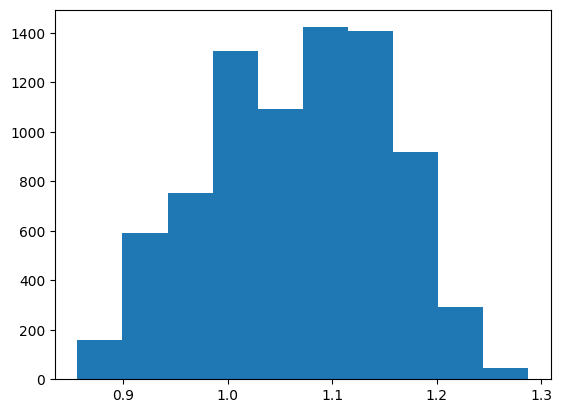

In [15]:
plt.hist(mcmc_samples.c1_.flatten())

0


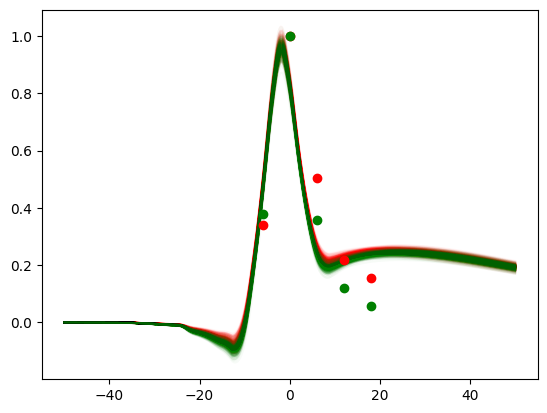

1


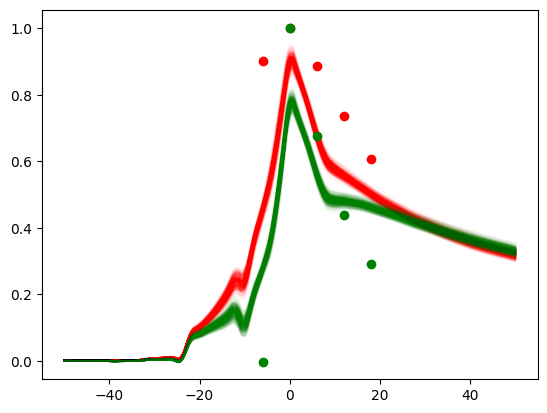

2


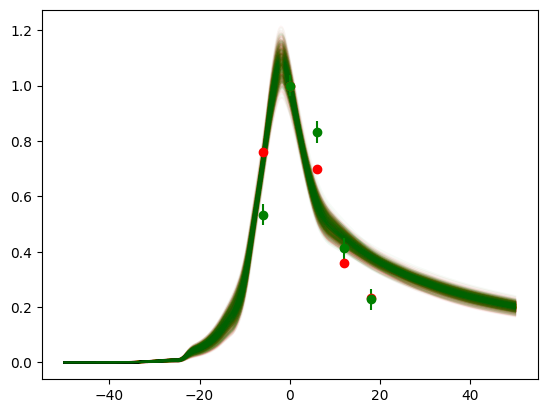

3


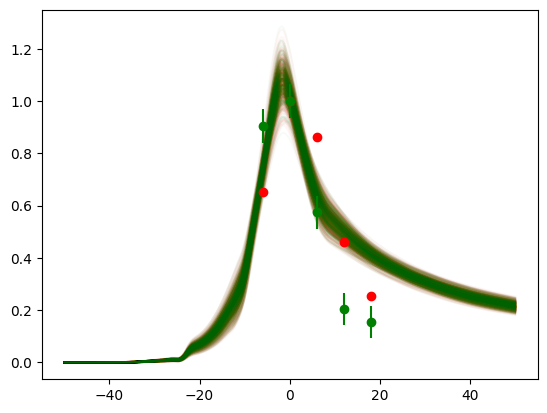

4


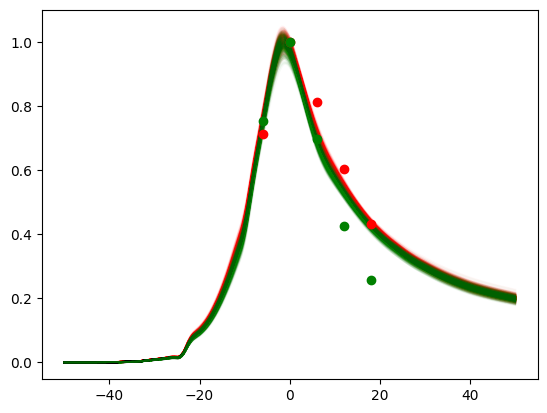

5


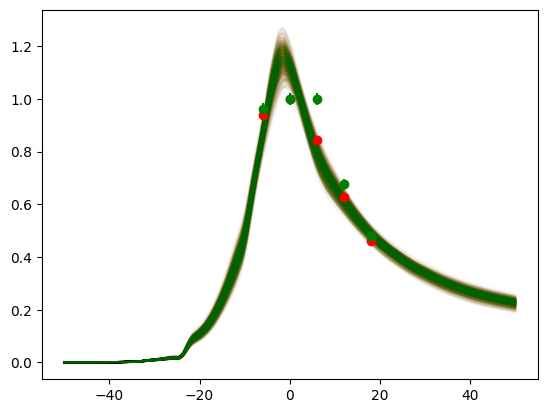

6


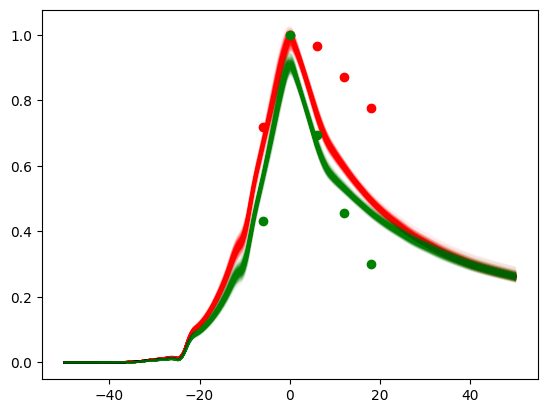

7


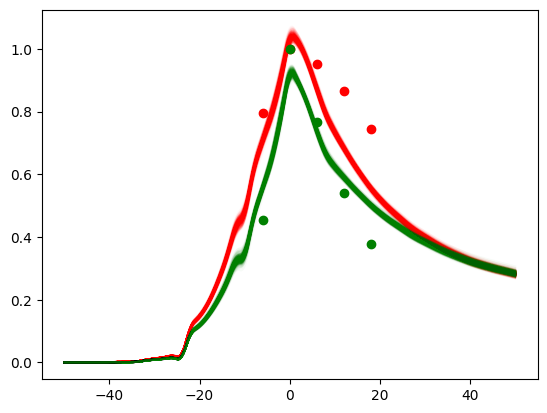

8


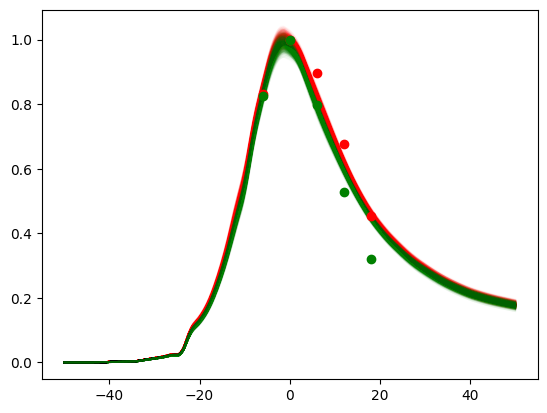

9


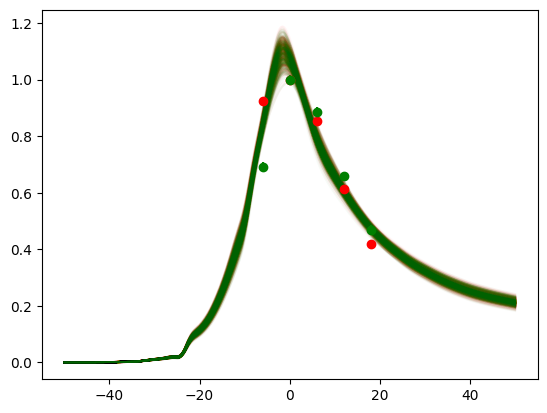

10


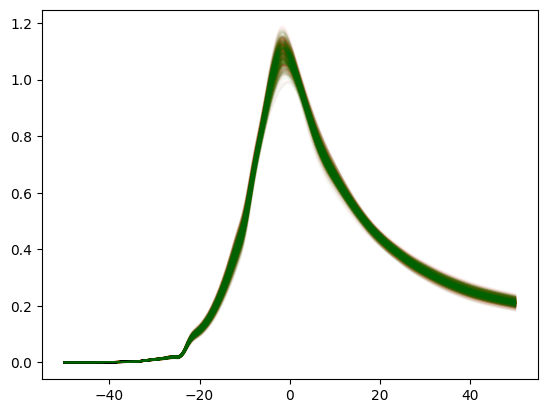

In [21]:
colors = ['r', 'g']
for event_num in range(len(index)):
    print(event_num)
    plt.figure()
    object_df = new_object_df[new_object_df['object_index']==event_num]
    for band in range(2):
        for sample_no in range(100):
            for chain_num in range(4):
                c1_ = mcmc_samples.c1_[sample_no, chain_num, event_num, band]
                c2 = mcmc_samples.c2[sample_no, chain_num, event_num, band]
                c3 = mcmc_samples.c3[sample_no, chain_num, event_num, band]
                c1 = c1_ - c2 - c3
#                 print(c1)
#                 print(c2)
#                 print(c3)
                
                predictions = parametric_fn_pcs(c1, c2, c3, pcs, np.arange(0,401, 1))
                #print( predictions)
                plt.plot(np.arange(-50, 50.25, .25), predictions, alpha=.03, color=colors[band])


        band_df = object_df[object_df['band_index']==band]
        plt.errorbar(band_df["time"], band_df["flux"], yerr=band_df["fluxerr"], fmt="o", color=colors[band])
    if event_num==10:
        break
    plt.show()